In [1]:
import imageio
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (10, 8)

#### Segment the heart
In this chapter, we'll work with magnetic resonance (MR) imaging data from the Sunnybrook Cardiac Dataset. The full image is a 3D time series spanning a single heartbeat. These data are used by radiologists to measure the ejection fraction: the proportion of blood ejected from the left ventricle during each stroke.

To begin, segment the left ventricle from

In [5]:
im = imageio.imread('./dataset/cardiac/SCD2001_MR_117.dcm')


In [6]:
# Smooth intensity values
im_filt = ndi.median_filter(im, size=3)

# Select high-intensity pixels
mask_start = np.where(im_filt > 60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)
print('Num. Labels:', nlabels)

Num. Labels: 26


Plot the labels array on top of the original image. To create an overlay, use np.where to convert values of 0 to np.nan. Then, plot the overlay with the rainbow colormap and set alpha=0.75 to make it transparent.

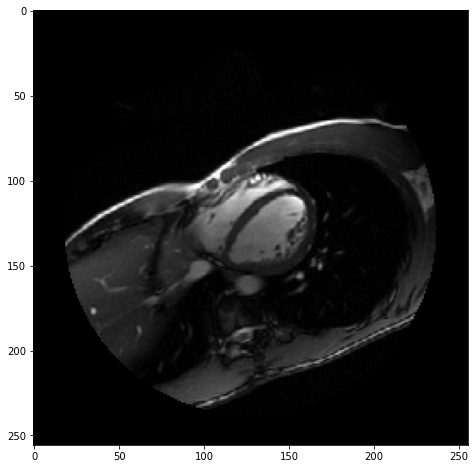

In [7]:
# Draw the image in grayscale (original)
plt.imshow(im, cmap='gray')

# Render the image
plt.show()

In [9]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')    
    plt.tight_layout()
    plt.show()

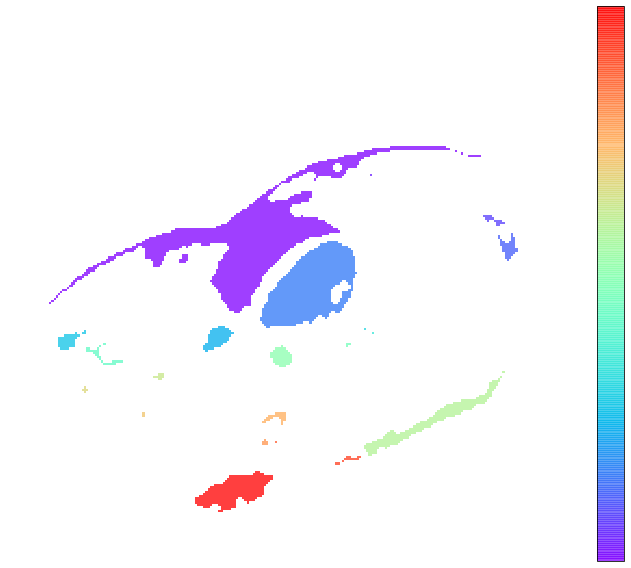

In [13]:
# Create a `labels` overlay
overlay = np.where(labels > 0, labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(overlay, cmap='rainbow', alpha=0.75)

plt.colorbar()
format_and_render_plot()

Robust image segmentation is an entire research domain, but the simple principle is to leverage intensity and location information to differentiate objects of interest from the background. Once labeled, the objects can be manipulated easily.


#### Select objects
Labels are like object "handles" - they give you a way to pick up whole sets of pixels at a time. To select a particular object:

- Find the label value associated with the object.
- Create a mask of matching pixels.


For this exercise, create a labeled array from the provided mask. Then, find the label value for the centrally-located left ventricle, and create a mask for it

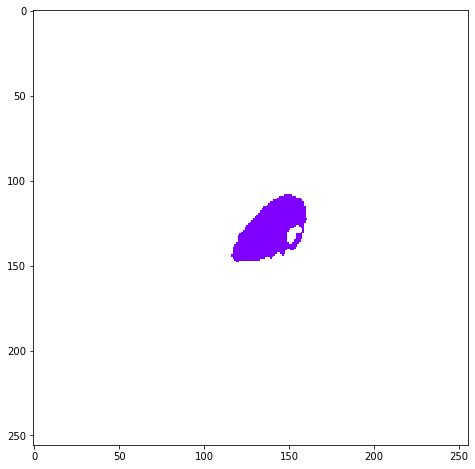

In [14]:
# Label the image "mask"
labels, nlabels = ndi.label(mask)

# Select left ventricle pixels
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, np.nan)

# Overlay selected label
plt.imshow(lv_mask, cmap='rainbow')
plt.show()

#### Extract objects
Extracting objects from the original image eliminates unrelated pixels and provides new images that can be analyzed independently.

The key is to crop images so that they only include the object of interest. The range of pixel indices that encompass the object is the bounding box.

For this exercise, use ndi.find_objects() to create a new image containing only the left ventricle.

In [16]:
# Create left ventricle mask
labels, nlabels = ndi.label(mask)
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, 0)

Find the bounding box indices for lv_mask. Print the number of objects found and the values for the first box.

In [17]:
# Find bounding box of left ventricle
bboxes = ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

Number of objects: 1
Indices for first box: (slice(107, 149, None), slice(116, 162, None))


- Select the portion of im that is within the left ventricle bounding box.
- Plot the cropped image.

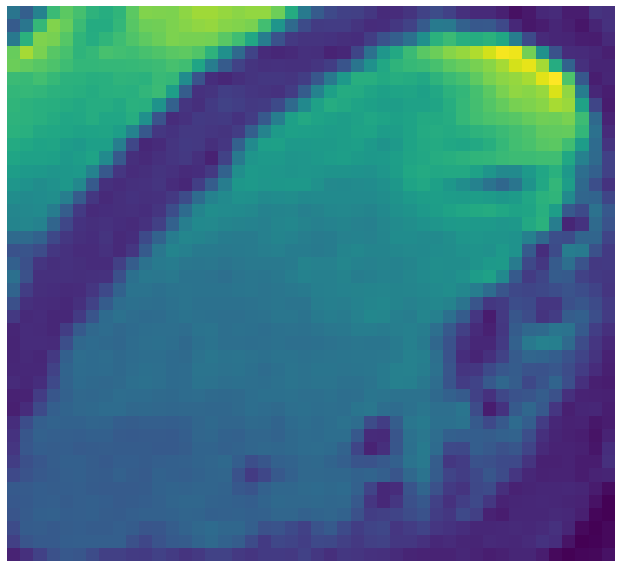

In [19]:
# Crop to the left ventricle (index 0)
im_lv = im[bboxes[0]]
# Plot the cropped image
plt.imshow(im_lv)
format_and_render_plot()

ndi.find_objects() becomes extremely useful when dealing with 3-dimensional objects that are harder to view at a glance.

#### Measure variance
SciPy measurement functions allow you to tailor measurements to specific sets of pixels:

- Specifying labels restricts the mask to non-zero pixels.
- Specifying index value(s) returns a measure for each label value.


For this exercise, calculate the intensity variance of vol with respect to different pixel sets. We have provided the 3D segmented image as labels: label 1 is the left ventricle and label 2 is a circular sample of tissue.


![aax](dataset/Ch3_L4_cardiac-vol-exercise.gif)

In [22]:
vol = imageio.volread('./dataset/cardiac')

# Variance for all pixels
var_all = ndi.variance(vol, labels=None, index=None)
print('All pixels:', var_all)

# Variance for labeled pixels
var_labels = ndi.variance(vol, labels, index=None)
print('Labeled pixels:', var_labels)

# Variance for each object
var_objects = ndi.variance(vol, labels, index=[1,2])
print('Left ventricle:', var_objects[0])
print('Other tissue:', var_objects[1])

Reading DICOM (examining files): 1/1 files (100.01/1 files (100.0%)
  Found 1 correct series.
All pixels: 1087.2698102833237
Labeled pixels: 2263.63265317682
Left ventricle: 3008.0415663536937
Other tissue: 4.5


#### Separate histograms
A poor tissue segmentation includes multiple tissue types, leading to a wide distribution of intensity values and more variance.

On the other hand, a perfectly segmented left ventricle would contain only blood-related pixels, so the histogram of the segmented values should be roughly bell-shaped.

For this exercise, compare the intensity distributions within vol for the listed sets of pixels. Use ndi.histogram, which also accepts labels and index arguments.

In [23]:
# Create histograms for selected pixels
hist1 = ndi.histogram(vol, min=0, max=255, bins=256)
hist2 = ndi.histogram(vol, 0, 255, 256, labels=labels)
hist3 = ndi.histogram(vol, 0, 255, 256, labels=labels, index=1)

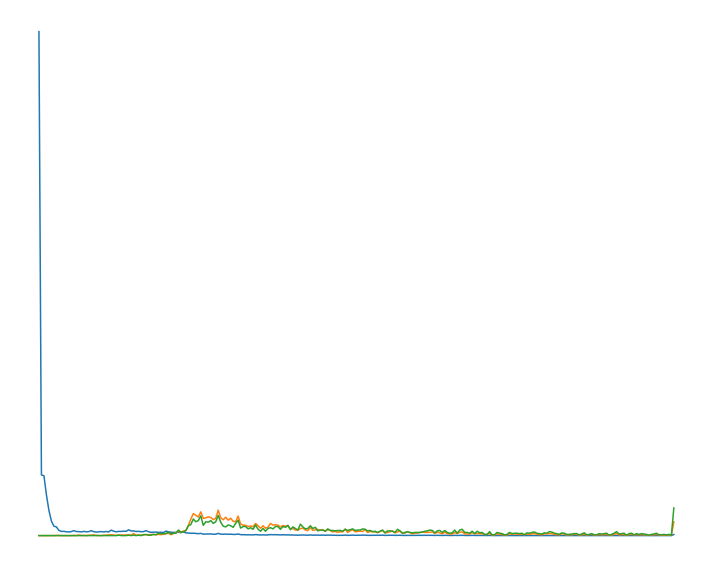

In [24]:
# Plot the histogram density
plt.plot(hist1 / hist1.sum(), label='All pixels')
plt.plot(hist2 / hist2.sum(), label='All labeled pixels')
plt.plot(hist3 / hist3.sum(), label='Left ventricle')
format_and_render_plot()

#### Calculate distance
A distance transformation calculates the distance from each pixel to a given point, usually the nearest background pixel. This allows you to determine which points in the object are more interior and which are closer to edges.

For this exercise, use the Euclidian distance transform on the left ventricle object in labels

In [31]:
# Calculate left ventricle distances
lv = np.where(labels == 1, 1, 0)
dists = ndi.distance_transform_edt(lv, sampling=vol.meta['sampling'])

# Report on distances
print('Max distance (mm):', ndi.maximum(dists))
print('Max location:', ndi.maximum_position(dists))

# Plot overlay of distances
overlay = np.where(dists[5] > 0, dists[5], np.nan) 


Max distance (mm): 20.324710798508892
Max location: (104, 118)


#### Pinpoint center of mass
The distance transformation reveals the most embedded portions of an object. On the other hand, ndi.center_of_mass() returns the coordinates for the center of an object.

The "mass" corresponds to intensity values, with higher values pulling the center closer to it.

For this exercise, calculate the center of mass for the two labeled areas. Then, plot them on top of the image.

Label 1 center: (102.47847701334709, 115.42674898446063)
Label 2 center: (77.51538461538462, 167.49615384615385)


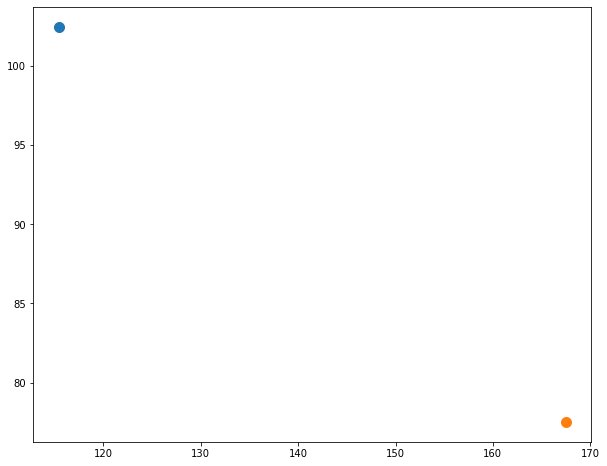

In [34]:
# Extract centers of mass for objects 1 and 2
coms = ndi.center_of_mass(vol, labels, index=[1,2])
print('Label 1 center:', coms[0])
print('Label 2 center:', coms[1])

# Add marks to plot
for c0, c1 in coms:
    plt.scatter(c1,c0, s=100, marker='o')
plt.show()

### Summarize the time series
The ejection fraction is the proportion of blood squeezed out of the left ventricle each heartbeat. To calculate it, radiologists have to identify the maximum volume (systolic volume) and the minimum volume (diastolic volume) of the ventricle.

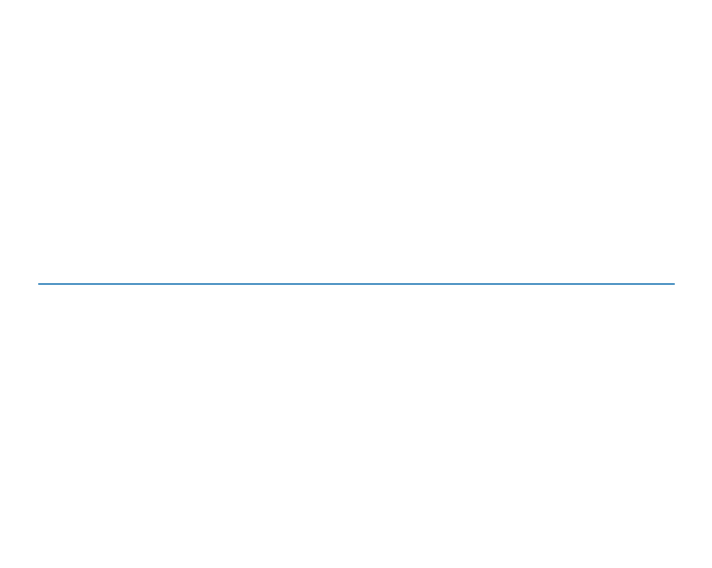

In [37]:
# Create an empty time series
ts = np.zeros(20)

# Calculate volume at each voxel
d0, d1 = vol.meta['sampling']
dvoxel = d0 * d1

# Loop over the labeled arrays
for t in range(20):
    nvoxels = ndi.sum(1, labels[t], index=1)
    ts[t] = nvoxels * dvoxel

# Plot the data
plt.plot(ts)
format_and_render_plot()

### Measure ejection fraction

In [40]:
# Get index of max and min volumes
tmax = np.argmax(ts)
tmin = np.argmin(ts)

In [41]:
# Calculate ejection fraction
ej_vol = ts.max() - ts.min()
ej_frac = ej_vol / ts.max()
print('Est. ejection volume (mm^3):', ej_vol)
print('Est. ejection fraction:', ej_frac)

Est. ejection volume (mm^3): 0.0
Est. ejection fraction: nan


C:\Users\aBr\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
